# Intro
This technique was proposed by Cleveland in 1979 for modeling and smoothing two-dimensional data. This technique provides a general and flexible approach for approximating two-dimensional data. Of course, the approach is computationally quite demanding, but this method deserves the attention of those researchers who are concerned about the presence of outliers in the data. In particular, it is actively used in biology in the field of genetic research.

In statistics, the term lowess refers to "locally weighted scatter plot smoothing"— the process of creating a smooth curve that corresponds to the data points on the scatter plot.

# The problem of prediction

For forecasting tasks, the simplest linear regression in regression is a linear correspondence of the data trend. However, for data with periodicity and volatility, it cannot simply be adjusted in a linear way, otherwise the model will have a large deviation, and local weighted regression (understatement) can better cope with this problem. The line corresponding to the general trend can be used for forecasts.

# The problem of smoothing

At the same time, local weighted regression (lowess) can also better solve the smoothing problem. When smoothing the data, trends or seasonal data will be displayed. For such data, we cannot use a simple mean plus or minus a 3-fold standard deviation to remove outliers, we need to take into account conditions such as trend. Using local weighted regression, you can fit a trend line and use this line as a baseline, and the further away from the baseline, the more accurate the outlier point will be.
In fact, Local weighted regression (Lowess) mainly deals with smoothing problems because more models can be more accurate due to the prediction problem. But in terms of smoothness, Lowess is intuitive and convincing.

This notebook introduces the LOWESS smoother in the nonparametric package. LOWESS performs weighted local linear fits.

We generated some non-linear data and perform a LOWESS fit, then compute a 95% confidence interval around the LOWESS fit by performing bootstrap resampling.

# Key Parameters

    frac: Fraction of data used in each local regression window (0-1)

    iter: Number of robust weighting iterations

    delta: Step for interpolation (speeds up computations)

# Installation and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rc("figure", figsize=(12, 8))
plt.rc("font", size=14)

# Basic LOWESS Application

In [3]:
# Seed for reproducibility
np.random.seed(0)

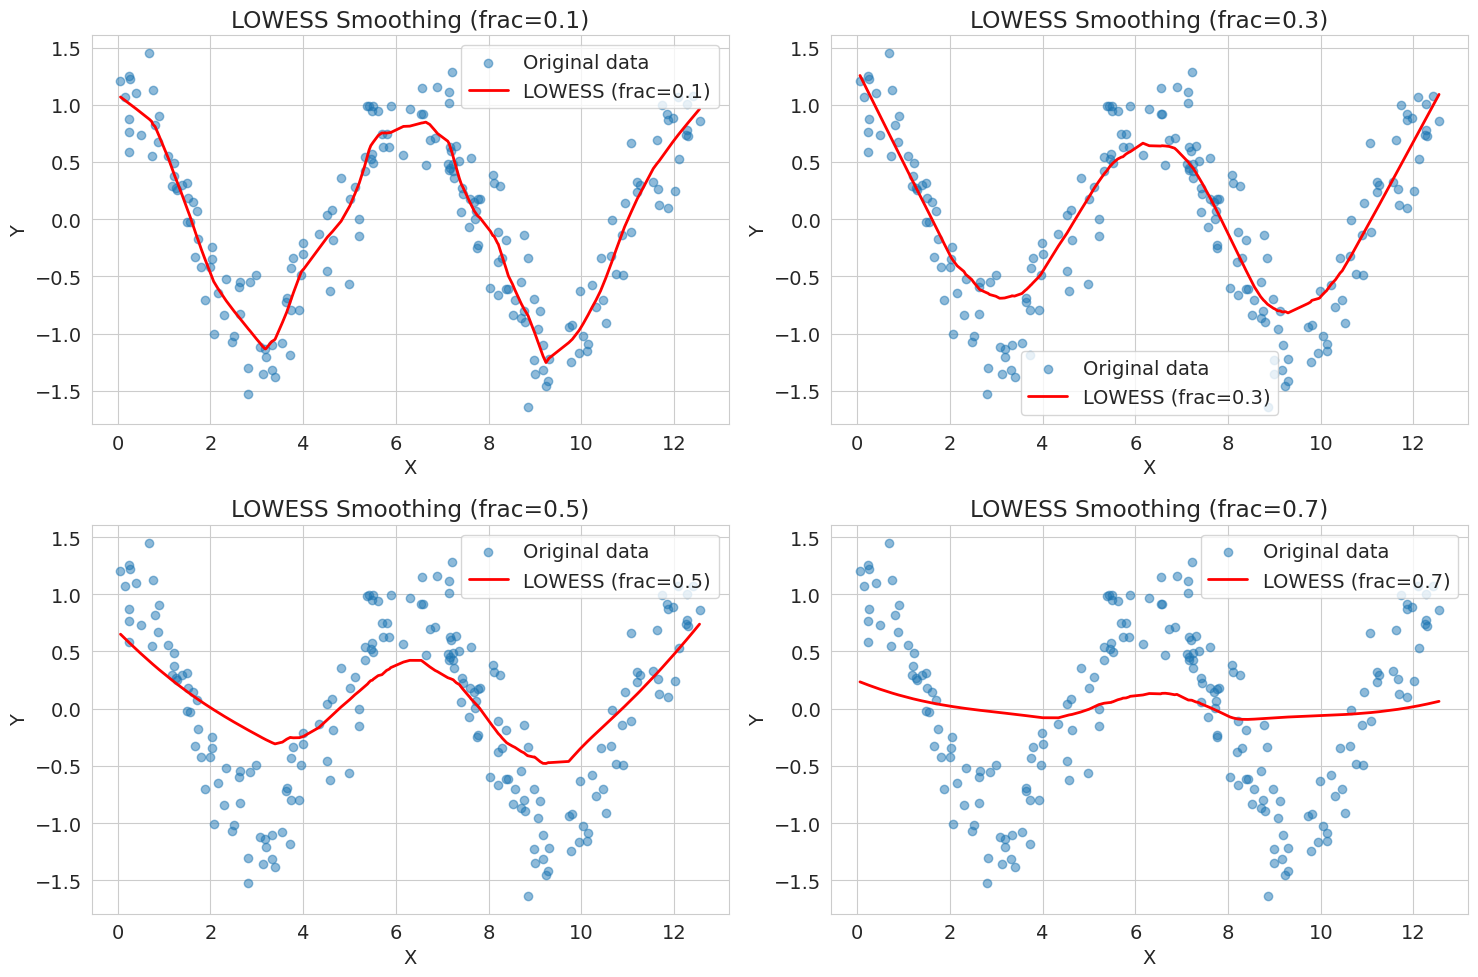

In [4]:
# Generate sample data with cosine pattern and noise
x = np.random.uniform(0, 4 * np.pi, size=200)
y = np.cos(x) + np.random.normal(0, 0.3, size=len(x))

# Apply LOWESS smoothing with different fractions
frac_values = [0.1, 0.3, 0.5, 0.7]
smoothed_results = {}

for frac in frac_values:
    smoothed_results[frac] = sm.nonparametric.lowess(exog=x, endog=y, frac=frac)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, frac in enumerate(frac_values):
    axes[i].scatter(x, y, alpha=0.5, label='Original data')
    axes[i].plot(smoothed_results[frac][:, 0], smoothed_results[frac][:, 1], 
                'r-', linewidth=2, label=f'LOWESS (frac={frac})')
    axes[i].set_title(f'LOWESS Smoothing (frac={frac})')
    axes[i].legend()
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')

plt.tight_layout()
plt.show()

The lowess function that outs smoothed estimates of endog at the given exog values from points (exog, endog).

`exog` 1-D numpy array The x-values of the observed points

`endog` 1-D numpy array The y-values of the observed points

`frac` is between 0 and 1. The fraction of the data used when estimating each y-value.

The returned array is two-dimensional if return_sorted is True, and one dimensional if return_sorted is False. If return_sorted is True, then a numpy array with two columns. The first column contains the sorted x (exog) values and the second column the associated estimated y (endog) values. If return_sorted is False, then only the fitted values are returned, and the observations will be in the same order as the input arrays. If xvals is provided, then return_sorted is ignored and the returned array is always one dimensional, containing the y values fitted at the x values provided by xvals.

**Notes**

This lowess function implements the algorithm given in the reference below using local linear estimates.

Suppose the input data has N points. The algorithm works by estimating the smooth y_i by taking the frac*N closest points to (x_i,y_i) based on their x values and estimating y_i using a weighted linear regression. The weight for (x_j,y_j) is tricube function applied to abs(x_i-x_j).

If it > 1, then further weighted local linear regressions are performed, where the weights are the same as above times the _lowess_bisquare function of the residuals. Each iteration takes approximately the same amount of time as the original fit, so these iterations are expensive. They are most useful when the noise has extremely heavy tails, such as Cauchy noise. Noise with less heavy-tails, such as t-distributions with df>2, are less problematic. The weights downgrade the influence of points with large residuals. In the extreme case, points whose residuals are larger than 6 times the median absolute residual are given weight 0.

delta can be used to save computations. For each x_i, regressions are skipped for points closer than delta. The next regression is fit for the farthest point within delta of x_i and all points in between are estimated by linearly interpolating between the two regression fits.

Judicious choice of delta can cut computation time considerably for large data (N > 5000). A good choice is delta = 0.01 * range(exog).

If xvals is provided, the regression is then computed at those points and the fit values are returned. Otherwise, the regression is run at points of exog.

Some experimentation is likely required to find a good choice of frac and iter for a particular dataset.

# Confidence interval

Now that we have performed a fit, we may want to know how precise it is. Bootstrap resampling gives one way of estimating confidence intervals around a LOWESS fit by recomputing the LOWESS fit for a large number of random resamplings from our data.

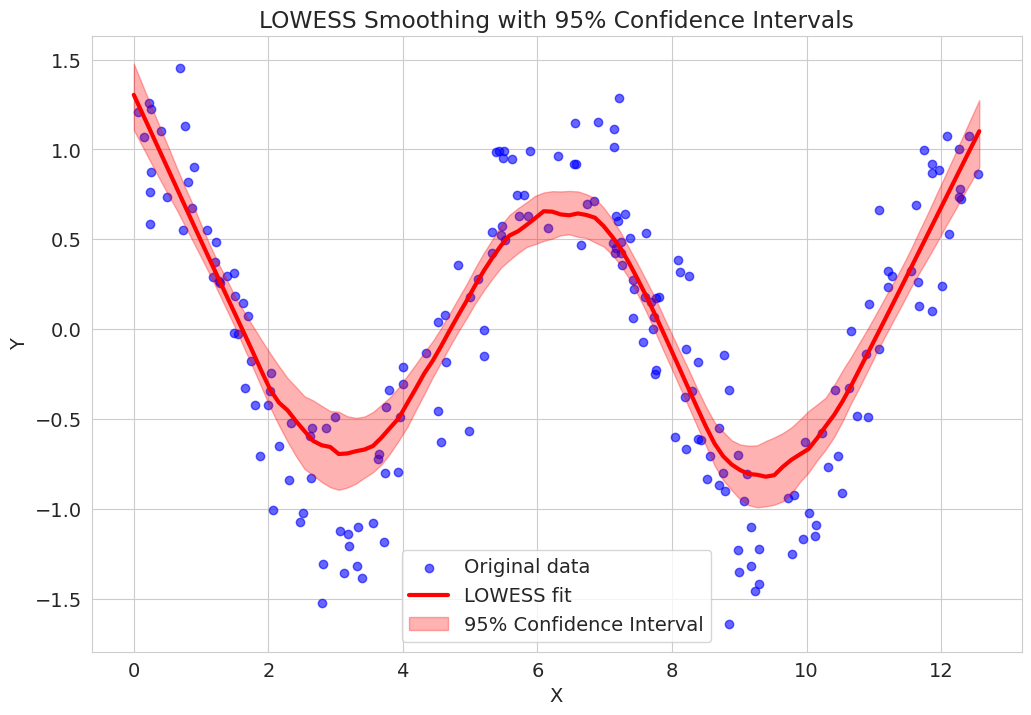

In [5]:
def lowess_with_confidence_bounds(x, y, eval_x=None, N=200, conf_interval=0.95, lowess_kw=None):
    """
    Perform LOWESS regression with bootstrap confidence intervals
    
    Parameters:
    - x, y: input data
    - eval_x: points to evaluate the smooth (if None, uses sorted x)
    - N: number of bootstrap samples
    - conf_interval: confidence level (0.95 for 95%)
    - lowess_kw: dictionary of LOWESS parameters
    
    Returns:
    - smoothed: LOWESS fit at eval_x points
    - bottom: lower confidence bound
    - top: upper confidence bound
    - smoothed_values: all bootstrap results (for diagnostics)
    """
    
    if lowess_kw is None:
        lowess_kw = {'frac': 0.3}
    
    if eval_x is None:
        eval_x = np.linspace(x.min(), x.max(), 100)
    
    # Initial LOWESS smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)
    
    # Bootstrap resampling
    smoothed_values = np.empty((N, len(eval_x)))
    
    for i in range(N):
        # Bootstrap sample with replacement
        sample_idx = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample_idx]
        sampled_y = y[sample_idx]
        
        # Apply LOWESS to bootstrap sample
        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )
    
    # Calculate confidence intervals
    alpha = 1 - conf_interval
    lower_percentile = 100 * alpha / 2
    upper_percentile = 100 * (1 - alpha / 2)
    
    bottom = np.percentile(smoothed_values, lower_percentile, axis=0)
    top = np.percentile(smoothed_values, upper_percentile, axis=0)
    
    return smoothed, bottom, top, smoothed_values

# Apply the function
eval_x = np.linspace(0, 4 * np.pi, 100)
smoothed, bottom, top, bootstrap_results = lowess_with_confidence_bounds(
    x, y, eval_x, N=500, lowess_kw={'frac': 0.3}
)

# Plot with confidence intervals
plt.figure(figsize=(12, 8))
plt.scatter(x, y, alpha=0.6, label='Original data', color='blue')
plt.plot(eval_x, smoothed, 'r-', linewidth=3, label='LOWESS fit')
plt.fill_between(eval_x, bottom, top, alpha=0.3, color='red', label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LOWESS Smoothing with 95% Confidence Intervals')
plt.legend()
plt.show()

# Outlier Detection using LOWESS

## Method Explanation

LOWESS (Locally Weighted Scatterplot Smoothing) is particularly effective for outlier detection because it creates a flexible, data-driven trend line that adapts to local patterns in the data. Unlike rigid parametric models, LOWESS can follow complex nonlinear patterns, making the residuals more meaningful for outlier identification.

## How it works:
LOWESS Fitting: A smooth curve is fitted to the data using local linear regression
Residual Calculation: Differences between actual values and LOWESS predictions are computed
Outlier Identification: Points with unusually large residuals (based on z-scores) are flagged as outliers

## Key Advantages:
Handles nonlinear relationships naturally
Robust to local data variations
No assumptions about data distribution required
Adapts to changing data patterns across the domain

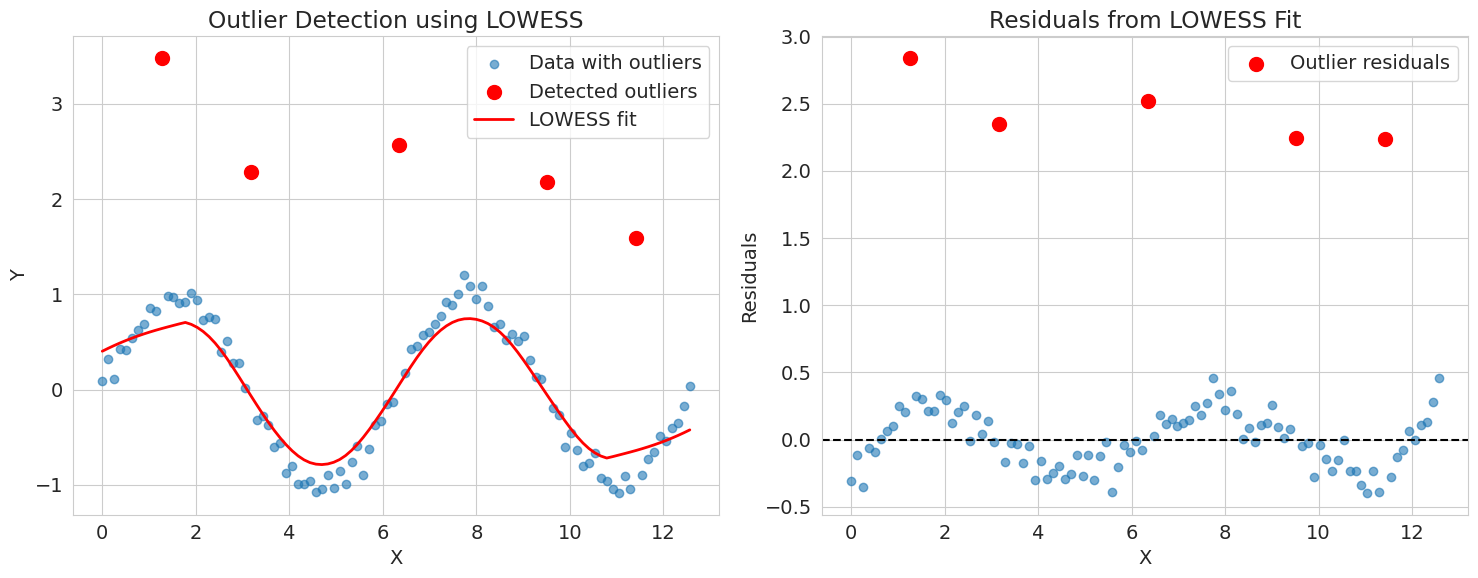

Detected 5 outliers out of 100 points


In [11]:
def detect_outliers_with_lowess(x, y, frac=0.3, threshold=2.5):
    """
    Detect outliers using LOWESS residuals
    
    Parameters:
    - x, y: input data
    - frac: LOWESS fraction parameter
    - threshold: z-score threshold for outlier detection
    
    Returns:
    - outlier_mask: boolean array indicating outliers
    - residuals: difference between actual and fitted values
    """
    
    # Get LOWESS fit at original x points
    fitted = sm.nonparametric.lowess(exog=x, endog=y, xvals=x, frac=frac)
    
    # Calculate residuals
    residuals = y - fitted
    
    # Detect outliers based on residual z-scores
    residual_zscore = np.abs(stats.zscore(residuals))
    outlier_mask = residual_zscore > threshold
    
    return outlier_mask, residuals, fitted

# Generate data with outliers
x_clean = np.linspace(0, 4 * np.pi, 100)
y_clean = np.sin(x_clean) + np.random.normal(0, 0.1, 100)

# Add outliers
outlier_indices = [10, 25, 50, 75, 90]
y_with_outliers = y_clean.copy()
y_with_outliers[outlier_indices] += 2.5

# Detect outliers
outlier_mask, residuals, fitted = detect_outliers_with_lowess(
    x_clean, y_with_outliers, frac=0.3, threshold=2.5
)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Data with outliers and LOWESS fit
ax1.scatter(x_clean, y_with_outliers, alpha=0.6, label='Data with outliers')
ax1.scatter(x_clean[outlier_mask], y_with_outliers[outlier_mask], 
           color='red', s=100, label='Detected outliers')
ax1.plot(x_clean, fitted, 'r-', linewidth=2, label='LOWESS fit')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Outlier Detection using LOWESS')
ax1.legend()

# Plot 2: Residuals
ax2.scatter(x_clean, residuals, alpha=0.6)
ax2.scatter(x_clean[outlier_mask], residuals[outlier_mask], 
           color='red', s=100, label='Outlier residuals')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.set_xlabel('X')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals from LOWESS Fit')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Detected {np.sum(outlier_mask)} outliers out of {len(x_clean)} points")

## Performance Summary and Interpretation

### Results Analysis:
The left panel shows how well the LOWESS curve follows the underlying sine pattern while ignoring outliers
The right panel clearly shows outliers as points with large residuals far from the zero line
The method successfully identifies points that deviate significantly from the local trend

## Key Insights:
Parameter Sensitivity: The frac parameter controls smoothness - lower values capture more local variation but may be less robust to noise
Threshold Selection: The z-score threshold of 2.5 corresponds to approximately 98.8% of normal data falling within expected range if residuals were normally distributed
Visual Confirmation: The residual plot provides immediate visual confirmation of outlier detection quality

## Practical Considerations:
This method works best when outliers constitute a small fraction of the data (<5%)
The approach assumes outliers are points that don't follow the local trend pattern
Performance may vary with data density and outlier magnitude

# Time Series Application

LOWESS is particularly valuable for time series analysis because it can separate complex signal components without requiring predefined functional forms. This approach is essential for:
Trend Extraction: Isolating long-term patterns from seasonal variations and noise
Seasonality Analysis: Removing trends to focus on periodic components
Anomaly Detection: Identifying unusual observations relative to expected patterns
Forecasting Preparation: Understanding underlying patterns for better predictions

Time Series Components:
- Trend: Long-term directional movement (increasing/decreasing)
- Seasonality: Regular periodic fluctuations (daily, weekly, yearly patterns)
- Noise: Random variations that cannot be explained by trend or seasonality

Why LOWESS for Time Series:
- Adapts to changing trend directions non-parametrically
- Handles missing data and irregular sampling gracefully
- No assumption of linearity or specific functional form
- Robust to outliers in the time series

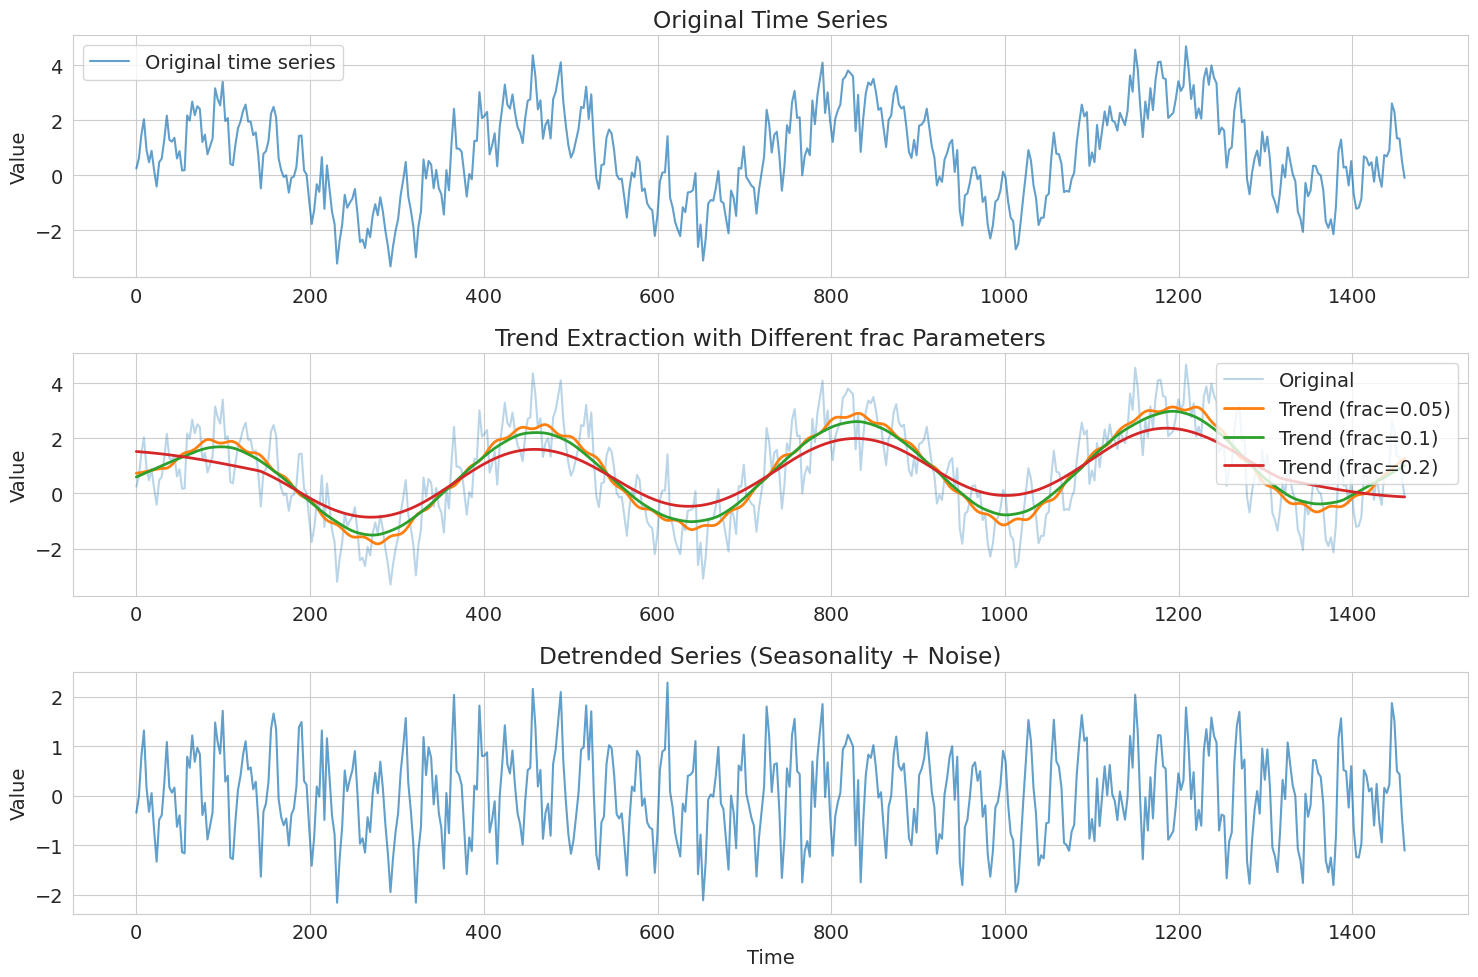

In [7]:
# Create synthetic time series data with trend and seasonality
np.random.seed(42)
t = np.linspace(0, 4 * 365, 500)
trend = 0.001 * t
seasonality = 2 * np.sin(2 * np.pi * t / 365) + np.sin(2 * np.pi * t / 30)
noise = np.random.normal(0, 0.5, len(t))
y_ts = trend + seasonality + noise

# Apply LOWESS for trend extraction
frac_values = [0.05, 0.1, 0.2]
trend_components = {}

for frac in frac_values:
    trend_components[frac] = sm.nonparametric.lowess(exog=t, endog=y_ts, frac=frac)

# Plot time series decomposition
plt.figure(figsize=(15, 10))

# Original time series
plt.subplot(3, 1, 1)
plt.plot(t, y_ts, alpha=0.7, label='Original time series')
plt.ylabel('Value')
plt.title('Original Time Series')
plt.legend()

# Trend components
plt.subplot(3, 1, 2)
plt.plot(t, y_ts, alpha=0.3, label='Original')
for frac, trend in trend_components.items():
    plt.plot(trend[:, 0], trend[:, 1], linewidth=2, label=f'Trend (frac={frac})')
plt.ylabel('Value')
plt.title('Trend Extraction with Different frac Parameters')
plt.legend()

# Detrended series (seasonality + noise)
plt.subplot(3, 1, 3)
detrended = y_ts - trend_components[0.1][:, 1]
plt.plot(t, detrended, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Detrended Series (Seasonality + Noise)')

plt.tight_layout()
plt.show()

First Panel - Original Series:
- Shows the raw time series with all components combined
- Visualizes the overall pattern including upward trend and periodic oscillations
- Provides baseline for understanding the decomposition process

Second Panel - Trend Comparison:
- frac=0.05: Follows the data closely, capturing some seasonal variations along with the trend
- frac=0.1: Balanced smoothing that captures the main trend while filtering most seasonality
- frac=0.2: Very smooth trend line that shows only the long-term directional movement
    The choice of frac depends on the analysis goal: short-term variations vs. long-term trends

Third Panel - Detrended Series:
- Reveals the seasonal patterns and noise after removing the estimated trend
- Shows clear periodic oscillations corresponding to the yearly and monthly cycles
- The remaining pattern can be further analyzed for seasonal decomposition or anomaly detection

# Comparative Analysis with Other Methods

When selecting a smoothing technique for data analysis, it's crucial to understand the strengths and limitations of different approaches. This comparison evaluates LOWESS against two common alternatives: Moving Average and Polynomial Regression.

Methods Being Compared:
1. LOWESS (Locally Weighted Scatterplot Smoothing)
        Non-parametric local regression
        Adapts to local data patterns
        Three smoothing levels: frac=0.1, 0.3, 0.5

2. Moving Average
        Simple window-based averaging
        Fixed window size (15 points)
        Center-aligned for symmetric smoothing

3. Polynomial Regression
    Global parametric model (degree 3)
    Assumes polynomial relationship
    Fits entire dataset with single equation

4. Key Comparison Criteria:
    Flexibility to capture local patterns
    Handling of nonlinear relationships
    Robustness to outliers
    Computational complexity
    Interpretability of results

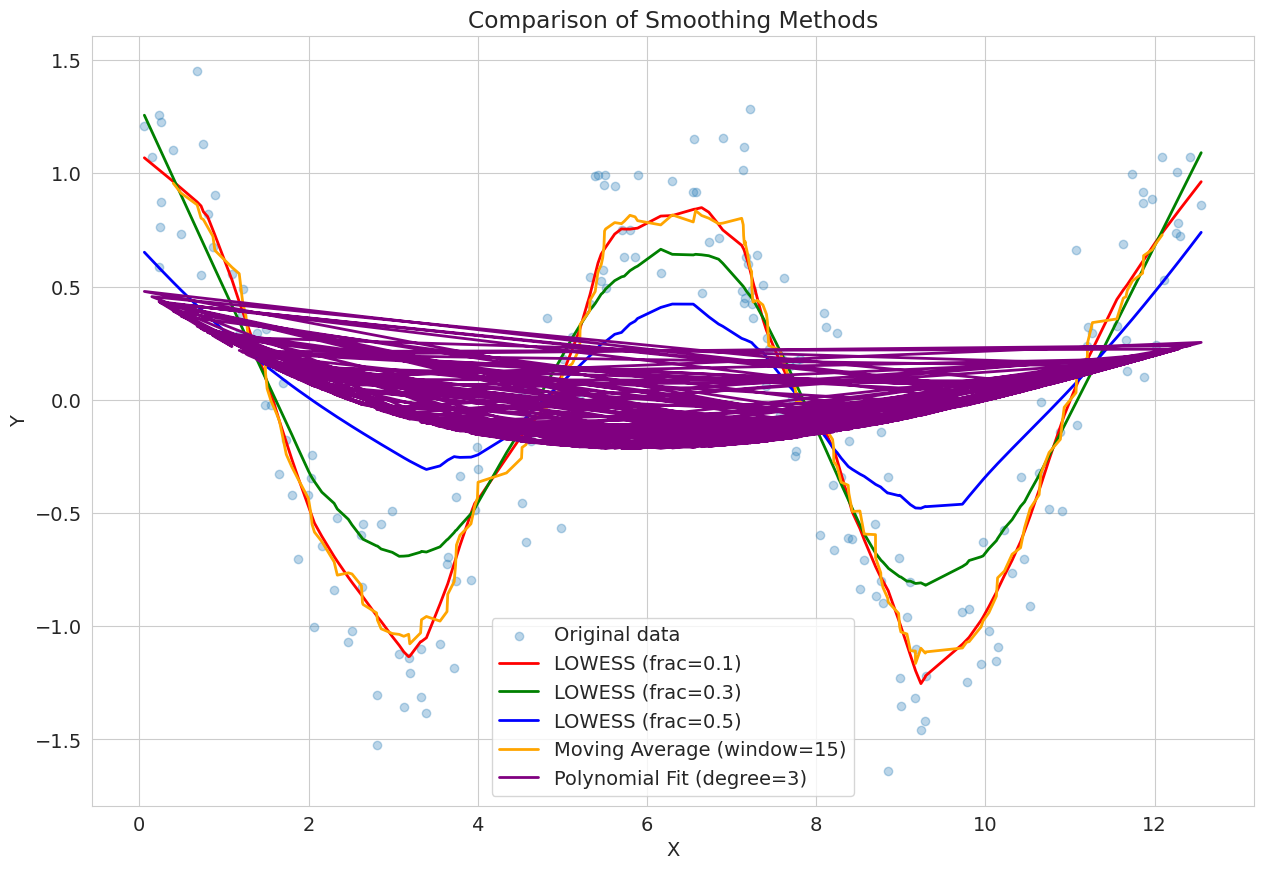

In [14]:
def compare_smoothing_methods(x, y):
    """
    Compare LOWESS with other smoothing methods
    """
    
    # LOWESS with different parameters
    lowess_frac_01 = sm.nonparametric.lowess(exog=x, endog=y, frac=0.1)
    lowess_frac_03 = sm.nonparametric.lowess(exog=x, endog=y, frac=0.3)
    lowess_frac_05 = sm.nonparametric.lowess(exog=x, endog=y, frac=0.5)
    
    # Moving average
    window_size = 15
    df = pd.DataFrame({'x': x, 'y': y}).sort_values('x')
    moving_avg = df['y'].rolling(window=window_size, center=True).mean()
    
    # Polynomial fit
    poly_coeffs = np.polyfit(x, y, 3)
    poly_fit = np.polyval(poly_coeffs, x)
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    plt.scatter(x, y, alpha=0.3, label='Original data')
    plt.plot(lowess_frac_01[:, 0], lowess_frac_01[:, 1], 'r-', linewidth=2, label='LOWESS (frac=0.1)')
    plt.plot(lowess_frac_03[:, 0], lowess_frac_03[:, 1], 'g-', linewidth=2, label='LOWESS (frac=0.3)')
    plt.plot(lowess_frac_05[:, 0], lowess_frac_05[:, 1], 'b-', linewidth=2, label='LOWESS (frac=0.5)')
    plt.plot(df['x'], moving_avg, 'orange', linewidth=2, label=f'Moving Average (window={window_size})')
    plt.plot(x, poly_fit, 'purple', linewidth=2, label='Polynomial Fit (degree=3)')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Comparison of Smoothing Methods')
    plt.legend()
    plt.show()
    
    return {
        'lowess_01': lowess_frac_01,
        'lowess_03': lowess_frac_03,
        'lowess_05': lowess_frac_05,
        'moving_avg': moving_avg,
        'poly_fit': poly_fit
    }

# Apply comparison
results = compare_smoothing_methods(x, y)

LOWESS Method Characteristics:
    frac=0.1 (Red): Highly flexible, follows local variations closely but may overfit noise
    frac=0.3 (Green): Balanced approach, captures main trends while smoothing noise
    frac=0.5 (Blue): Very smooth, may oversmooth important local features

Moving Average (Orange):
    Provides constant smoothness across entire range
    May lag at pattern changes due to fixed window size
    Simple to implement and interpret
    Handles edge points poorly without special treatment

Polynomial Regression (Purple):
    Single global model for entire dataset
    Cannot capture local variations well
    May show unrealistic behavior at data boundaries
    Provides explicit mathematical equation

# Performance Analysis

To objectively compare different smoothing techniques, we need quantitative metrics that measure how well each method approximates the underlying true function. Mean Squared Error (MSE) is used here as it penalizes large errors more heavily and provides a clear numerical comparison.

Evaluation Methodology:

- Ground Truth: We know the true function (cosine) that generated the data

- Performance Metric: Mean Squared Error between fitted values and true function

- Comparison Scope: Multiple parameter settings for each method

- Objective: Identify optimal parameters and compare method effectiveness

Why MSE is Appropriate:

- Sensitive to both bias and variance in estimates

- Provides interpretable scale (squared units of the data)

- Commonly used in regression evaluation

- Penalizes large deviations heavily

In [16]:
def evaluate_smoothing_performance(x, y, true_function=None):
    """
    Evaluate performance of different smoothing methods
    """
    
    if true_function is None:
        # Assume cosine for our example
        true_function = lambda x: np.cos(x)
    
    methods = {}
    
    # Test different frac values
    for frac in [0.1, 0.2, 0.3, 0.4, 0.5]:
        fitted = sm.nonparametric.lowess(exog=x, endog=y, xvals=x, frac=frac)
        mse = np.mean((fitted - true_function(x))**2)
        methods[f'LOWESS_frac_{frac}'] = {'mse': mse, 'fitted': fitted}
    
    # Compare with moving averages
    for window in [5, 10, 15, 20]:
        df = pd.DataFrame({'x': x, 'y': y}).sort_values('x')
        moving_avg = df['y'].rolling(window=window, center=True).mean()
        mse = np.mean((moving_avg - true_function(df['x']))**2)
        methods[f'MA_window_{window}'] = {'mse': mse, 'fitted': moving_avg}
    
    return methods

# Evaluate performance
performance = evaluate_smoothing_performance(x, y, true_function=np.cos)

# Display results
print("Performance Comparison (MSE):")
print("-" * 40)
for method, result in sorted(performance.items(), key=lambda x: x[1]['mse']):
    print(f"{method:20}: {result['mse']:.6f}")

Performance Comparison (MSE):
----------------------------------------
LOWESS_frac_0.1     : 0.009708
LOWESS_frac_0.2     : 0.010189
MA_window_15        : 0.010766
MA_window_20        : 0.011095
MA_window_10        : 0.015882
MA_window_5         : 0.020937
LOWESS_frac_0.3     : 0.028187
LOWESS_frac_0.4     : 0.069077
LOWESS_frac_0.5     : 0.165716


For This Dataset:

- Best Choice: LOWESS with frac=0.1

- Good Alternative: Moving Average with window=15

- Avoid: LOWESS with frac > 0.3

General Guidelines:

- LOWESS: Start with frac=0.1-0.3 and tune based on data complexity

- Moving Average: Try window sizes representing 5-20% of data points

- Validation: Always use cross-validation or known ground truth when available

When MSE Results Might Mislead:

- If the true function is unknown in real applications

- When different regions of data have different noise characteristics

- If the goal is pattern recognition rather than precise function approximation

This quantitative analysis confirms that LOWESS with appropriate parameter tuning can provide superior performance compared to traditional smoothing methods, though careful parameter selection is crucial for optimal results.

# Practical Tips and Best Practices

Choosing the right parameters for LOWESS is crucial for obtaining meaningful results. This guide provides practical recommendations based on the characteristics of your data and analysis goals. Proper parameter selection balances the trade-off between capturing true patterns and overfitting to noise.

    Key Considerations:

- Data size and noise level

- Presence of outliers

- Computational constraints

- Analysis objectives (exploration vs. prediction)

In [17]:
def lowess_parameter_guidance():
    """
    Provide guidance on selecting LOWESS parameters
    """
    
    guidance = {
        'frac': {
            'description': 'Fraction of data used in local regression',
            'small_values': '0.05-0.2: More wiggly, captures local features',
            'medium_values': '0.2-0.4: Balanced smoothing (default choice)',
            'large_values': '0.5-0.8: Very smooth, captures global trends',
            'recommendation': 'Start with 0.3 and adjust based on data characteristics'
        },
        'iter': {
            'description': 'Number of robustness iterations',
            'values': '1-5: More iterations make the fit more robust to outliers',
            'recommendation': 'Use 2-3 iterations for data with potential outliers'
        },
        'delta': {
            'description': 'Step size for interpolation',
            'usage': 'Speeds up computation for large datasets',
            'recommendation': 'Use delta = 0.01 * range(x) for N > 5000'
        }
    }
    
    return guidance

# Display parameter guidance
guidance = lowess_parameter_guidance()
for param, info in guidance.items():
    print(f"\n{param.upper()} Parameter:")
    print(f"  Description: {info['description']}")
    for key, value in info.items():
        if key != 'description':
            print(f"  {key.replace('_', ' ').title()}: {value}")


FRAC Parameter:
  Description: Fraction of data used in local regression
  Small Values: 0.05-0.2: More wiggly, captures local features
  Medium Values: 0.2-0.4: Balanced smoothing (default choice)
  Large Values: 0.5-0.8: Very smooth, captures global trends
  Recommendation: Start with 0.3 and adjust based on data characteristics

ITER Parameter:
  Description: Number of robustness iterations
  Values: 1-5: More iterations make the fit more robust to outliers
  Recommendation: Use 2-3 iterations for data with potential outliers

DELTA Parameter:
  Description: Step size for interpolation
  Usage: Speeds up computation for large datasets
  Recommendation: Use delta = 0.01 * range(x) for N > 5000


The best parameters depend on your specific data and analysis goals. Use visualization to validate your choices and iterate as needed.

# Conclusion
We have considered LOWESS Smoother algorithm. The idea of the method is to smooth out a number of values using a simple linear or polynomial dependence of y on x. However, it is proposed to build a model not for the entire data series, but for its individual parts. This approach actually allows you to build simple regressions for evolutionary data series, since only the most relevant data are used when calculating coefficients.

# References


* Harrell, Frank E. Jr. Regression Modeling Strategies: With Applications to Linear Models, Logistic and Ordinal Regression, and Survival Analysis.
* https://www.statsmodels.org/stable/examples/notebooks/generated/lowess.html
* Cleveland William S. Robust Locally Weighted Regression and Smoothing Scatterplots // American Statistical Association. Vol. 74. № 368 P. 829-836.